<a href="https://colab.research.google.com/github/beuholanda/tutorials/blob/master/english/data_processing/lessons/bridge_observations_tps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Processing Bridge Observations

##Import neccessary Python packages

In [ ]:
import re                         # for regular expressions
import numpy as np                # for vector/matri operations
import matplotlib.pyplot as plt   # for charts
import pandas as pd               # for table like data structures
from datetime import datetime, timedelta  # for time/date handling

##Processing Robotic total station data

Download total station data

In [ ]:
!gdown --id 1uYYOkjyxWmrFEWwnb96Wk3IBf5nRPzhR -O sample_data/bridge_tps.txt

Downloading...
From: https://drive.google.com/uc?id=1uYYOkjyxWmrFEWwnb96Wk3IBf5nRPzhR
To: /content/sample_data/bridge_tps.txt
100% 142k/142k [00:00<00:00, 53.9MB/s]


Unfortunately, in the space delimited text file, there are spaces in the time if the minutes or the seconds are less than '10'. Furthermore, sometimes the seconds are provided as '60', which Python identifies as an error. Using grep, let's display the first 10 records of these rows from the file:

```
TPS1200        -15.6389   198.3699    4.7584    --------  0.006  15:10:58
TPS1201        -15.6390   198.3699    4.7599    --------  0.006  15:10:59
TPS1202        -15.6373   198.3701    4.7584    --------  0.006  15:10:60
TPS1203        -15.6360   198.3702    4.7585    --------  0.006  15:11: 1
TPS1204        -15.6374   198.3701    4.7574    --------  0.006  15:11: 2
TPS1205        -15.6399   198.3700    4.7531    --------  0.006  15:11: 3
TPS1206        -15.6371   198.3691    4.7556    --------  0.006  15:11: 4
```

Let's write a short Python program to correct the aforementioned issues:

In [ ]:
pattern = re.compile('[0-2][0-9]:[0-6][0-9]:60')  # pattern for 60 seconds
with open('sample_data/bridge_tps.txt') as fp:    # input file
  with open('sample_data/tps.txt', 'w') as fo:    # output file
    for line in fp:
      line = line.replace(': ', ':0')             # space in minutes or seconds
      p = pattern.search(line)                    # are there 60 seconds?
      if p:                                       # there is :60 seconds in string
        orig = p.group()                          # save match part
        tm = orig.replace(':60', ':59')           # change to valid time decreasing with 1 second
        t = datetime.strptime(tm, '%H:%M:%S') + timedelta(seconds=1)  # add 1 second back
        line = line.replace(orig, t.strftime('%H:%M:%S')) # convert back to string and replace original
      print(line, end='', file=fo)                # write to output file


Let's load the data into pandas data frame. Please correct the date!

In [ ]:
names = ["east", "north", "elev", "dummy", "std", "time"]
rts_data = pd.read_csv('sample_data/tps.txt', sep='\s+', names=names, skiprows=3)
rts_data['time'] = pd.to_datetime('2022-03-10 ' + rts_data['time']) #, format='%H:%M:%S')
print(f'{rts_data.shape[0]} records loaded')

1886 records loaded


Let's plot the RTS data.

Text(0.5, 1.0, 'Elevations')

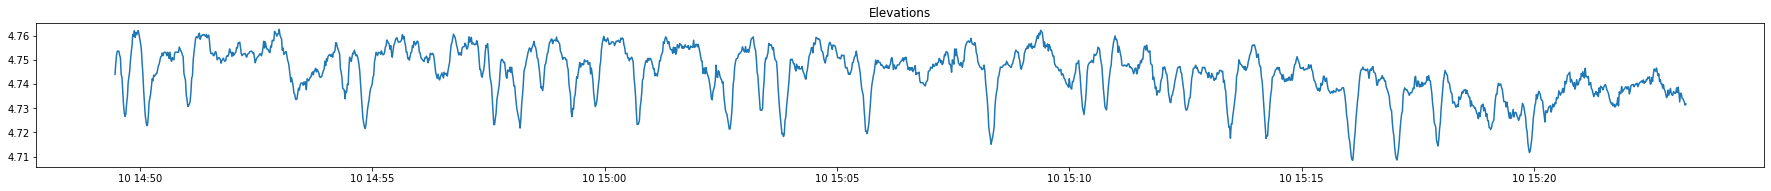

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(rts_data['time'], rts_data['elev'])
ax.set_title('Elevations')

Do we have gaps in the data series?

In [ ]:
deltas = rts_data['time'].diff()[1:]        # time difference from previous record
dd = deltas[deltas > timedelta(seconds=1)]  # select row where diff > 1 sec
print(f'{rts_data.shape[0]} records with {dd.size} gaps')

1886 records with 143 gaps


Let's fill the gaps.

In [ ]:
t0 = rts_data['time'].min()
t0 = datetime(t0.year, t0.month, t0.day, 0, 0, 0)
dt = (rts_data['time'] - t0).dt.total_seconds()  # time difference from midnight
de = rts_data['elev'] - rts_data['elev'].max()
dt = dt.to_numpy().astype(int)
de = (de.to_numpy() * 1000).astype(int)   # change to mm
rts_x = np.arange(dt[0], dt[-1]+1)        # create serie of seconds
rts_y = np.interp(rts_x, dt, de)          # interpolate missing deflection (linear)
print(f'max deflection: {rts_y.min():.1f} mm')

max deflection: -54.0 mm


Now, let's display a chart containing the critical deflections. For that, the the *critical* values are based on max deflection.

247 seconds under critical


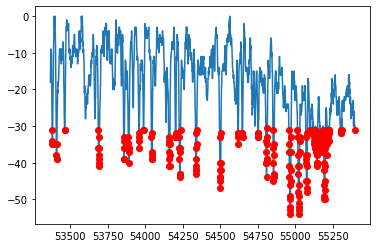

In [ ]:
critical = -30                            # critical deflection value
rts = np.c_[rts_x, rts_y]                 # numpy matrix from x, y vectors
rts_bus = rts[rts[:,1] < critical]        # select below critical
print(f'{rts_bus.shape[0]} seconds under critical')
plt.plot(rts_x, rts_y)                    # plot all data
plt.plot(rts_bus[:,0], rts_bus[:,1], 'ro')  # plot critical points

As it is possible to check, there is a decreasing trend in the data. Let's remove it.

max deflection: -48.9 mm
200 seconds under critical


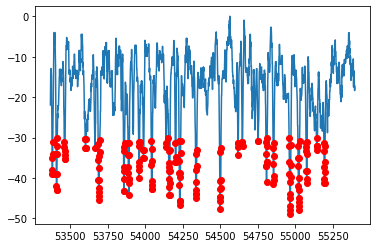

In [ ]:
rts_y = rts_y - np.polyval(np.polyfit(rts_x, rts_y, 2), rts_x)  # remove second order trend
rts_y = rts_y - rts_y.max()               # move max deflection value to zero
print(f'max deflection: {rts_y.min():.1f} mm')
rts = np.c_[rts_x, rts_y]                 # numpy matrix from x, y vectors
rts_bus = rts[rts[:,1] < critical]
print(f'{rts_bus.shape[0]} seconds under critical')
plt.plot(rts_x, rts_y)
plt.plot(rts_bus[:,0], rts_bus[:,1], 'ro')

Finaly, let's try to estimate the bus passes, saving the results to a file.

In [ ]:
start = 0                               # start row index of the first bus
bus = []
for i in range(1, rts_bus.shape[0]):    # for each row except first
  if rts_bus[i,0] - rts_bus[i-1,0] > 1: # gap -> new bus arrived
    if i-start-1 > 2:                   # pass longer than 2 seconds?
      bus.append((np.average(rts_bus[start:i,0]),
                  np.min(rts_bus[start:i,1]),
                  i-start-1))           # store time, max deflection and duration (sec)
    start = i
# add last
if rts_bus.shape[0] - start > 2:
  bus.append((np.average(rts_bus[start:,0]),
              np.min(rts_bus[start:,1]),
              rts_bus.shape[0]-start))
print(f'{len(bus)} busses found')
print(f'time  max.defl.  duration')
fo = open('sample_data/rts_bus.txt', 'w')
for b in bus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

23 busses found
time  max.defl.  duration
14:49:41 -39.0     5
14:50:10 -43.1     8
14:51:02 -35.2     5
14:53:21 -32.5     5
14:54:51 -45.5    11
14:57:38 -43.3     7
14:58:09 -44.3     9
14:59:19 -40.1     6
14:59:48 -35.0     3
15:00:43 -42.8     7
15:02:39 -44.2    11
15:03:22 -36.0     4
15:03:50 -46.8    11
15:05:39 -45.0     8
15:08:19 -47.6     9
15:10:18 -34.4     3
15:13:28 -41.1     8
15:14:15 -41.5     6
15:16:04 -48.9    12
15:17:02 -48.0    11
15:17:55 -41.2     8
15:19:04 -33.0     4
15:19:54 -41.2     9


Let's display the results:

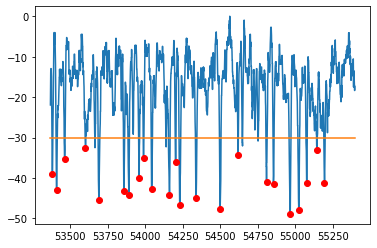

In [ ]:
plt.plot(rts_x, rts_y)
plt.plot([rts_x.min(), rts_x.max()], [critical, critical])
plt.plot([b[0] for b in bus], [b[1] for b in bus], 'ro')

##GNSS data processing

This processing is very similar to RTS data processing.

First, let's download the GNSS data.

In [ ]:
!gdown --id 1wGB0UD_0YupPjwKVLqTgs5FZDZMkHC6I -O sample_data/bridge_gps.txt
!head -10 sample_data/bridge_gps.txt

Downloading...
From: https://drive.google.com/uc?id=1wGB0UD_0YupPjwKVLqTgs5FZDZMkHC6I
To: /content/sample_data/bridge_gps.txt
100% 228k/228k [00:00<00:00, 45.6MB/s]

RTCM-Ref 0271        667568.278   271801.864     252.050        --------   2021.04.28   14:43:24
RTCM-Ref 0207        650684.476   237444.172     137.177        --------   2021.04.28   14:43:29
GPS_Auto_2172        650134.203   238537.987     116.298        --------   2021.04.28   14:44:10
GPS_Auto_2173        650134.204   238537.988     116.296        --------   2021.04.28   14:44:11
GPS_Auto_2174        650134.204   238537.992     116.296        --------   2021.04.28   14:44:12
GPS_Auto_2175        650134.209   238537.991     116.297        --------   2021.04.28   14:44:13
GPS_Auto_2176        650134.206   238537.989     116.303        --------   2021.04.28   14:44:14
GPS_Auto_2177        650134.204   238537.986     116.294        --------   2021.04.28   14:44:15
GPS_Auto_2178        650134.202   238537.989     116.294  

Based on the above, we should use only the lines starting with *GPS_Auto*. Furthermore, please note that the seconds are sometimes '60' as well. 

Based on that, let's write a short Python program to select the lines and correct the '60' seconds issue:

In [ ]:
pattern = re.compile('[0-2][0-9]:[0-6][0-9]:60')  # pattern for 60 seconds
pattern1 = re.compile('GPS_Auto_[0-9]')           # pattern for line selection
with open('sample_data/bridge_gps.txt') as fp:    # input file
  with open('sample_data/gps.txt', 'w') as fo:    # output file
    for line in fp:
      if pattern1.match(line):                    # line pattern match
        p = pattern.search(line)                  # are there 60 seconds?
        if p:                                     # there is :60 seconds in string
          orig = p.group()                        # save match part
          tm = orig.replace(':60', ':59')         # change to valid time decreasing with 1 second
          t = datetime.strptime(tm, '%H:%M:%S') + timedelta(seconds=1)  # add 1 second back
          line = line.replace(orig, t.strftime('%H:%M:%S')) # convert back to string and replace original
        print(line, end='', file=fo)              # write to output file
!head -10 sample_data/gps.txt

GPS_Auto_2172        650134.203   238537.987     116.298        --------   2021.04.28   14:44:10
GPS_Auto_2173        650134.204   238537.988     116.296        --------   2021.04.28   14:44:11
GPS_Auto_2174        650134.204   238537.992     116.296        --------   2021.04.28   14:44:12
GPS_Auto_2175        650134.209   238537.991     116.297        --------   2021.04.28   14:44:13
GPS_Auto_2176        650134.206   238537.989     116.303        --------   2021.04.28   14:44:14
GPS_Auto_2177        650134.204   238537.986     116.294        --------   2021.04.28   14:44:15
GPS_Auto_2178        650134.202   238537.989     116.294        --------   2021.04.28   14:44:16
GPS_Auto_2179        650134.204   238537.985     116.296        --------   2021.04.28   14:44:17
GPS_Auto_2180        650134.205   238537.990     116.298        --------   2021.04.28   14:44:18
GPS_Auto_2181        650134.205   238537.992     116.299        --------   2021.04.28   14:44:19


Now, let's load the data into a pandas data frame:

In [ ]:
names = ['id', 'east', 'north', 'elev', 'dummy', 'date', 'time']
gps_data = pd.read_csv('sample_data/gps.txt', sep='\s+', names=names)
gps_data['time'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['time'])
gps_data.drop(columns=['dummy', 'date'], inplace=True)
gps_data[0:10]

,id,east,north,elev,time
0,GPS_Auto_2172,650134.203,238537.987,116.298,2021-04-28 14:44:10
1,GPS_Auto_2173,650134.204,238537.988,116.296,2021-04-28 14:44:11
2,GPS_Auto_2174,650134.204,238537.992,116.296,2021-04-28 14:44:12
3,GPS_Auto_2175,650134.209,238537.991,116.297,2021-04-28 14:44:13
4,GPS_Auto_2176,650134.206,238537.989,116.303,2021-04-28 14:44:14
5,GPS_Auto_2177,650134.204,238537.986,116.294,2021-04-28 14:44:15
6,GPS_Auto_2178,650134.202,238537.989,116.294,2021-04-28 14:44:16
7,GPS_Auto_2179,650134.204,238537.985,116.296,2021-04-28 14:44:17
8,GPS_Auto_2180,650134.205,238537.990,116.298,2021-04-28 14:44:18
9,GPS_Auto_2181,650134.205,238537.992,116.299,2021-04-28 14:44:19


Let's plot the GPS data.

Text(0.5, 1.0, 'Elevations')

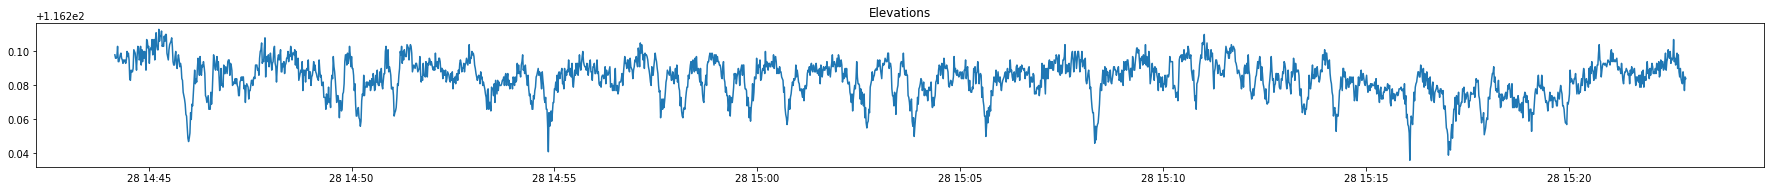

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(gps_data['time'], gps_data['elev'])
ax.set_title('Elevations')


Do we have gaps in the data serie?

In [ ]:
deltas = gps_data['time'].diff()[1:]        # time difference from previous record
dd = deltas[deltas > timedelta(seconds=1)]  # select row where diff > 1 sec
print(f'{gps_data.shape[0]} records with {dd.size} gaps')

2324 records with 0 gaps


As it is possible to check, there are no gaps.

Therefore, let's prepare the data and display a chart with the critical deflections, where the *critical* values are based on the max deflection.

In [ ]:
t0 = gps_data['time'].min()
t0 = datetime(t0.year, t0.month, t0.day, 0, 0, 0) # keep day
dt = (gps_data['time'] - t0).dt.total_seconds()   # time difference from midnight
de = gps_data['elev'] - gps_data['elev'].max()
dt = dt.to_numpy().astype(int)
de = (de.to_numpy() * 1000).astype(int)   # change to mm
gps_x = dt
gps_y = de
print(f'max deflection: {rts_y.min():.1f} mm')

max deflection: -48.9 mm


292 seconds under critical


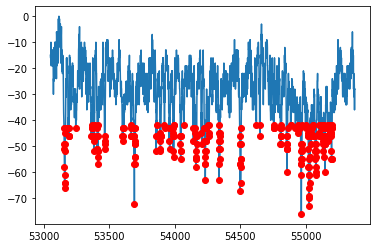

In [ ]:
critical = -40
gps = np.c_[gps_x, gps_y]                 # numpy matrix from x, y vectors
gps_bus = gps[gps[:,1] < critical]        # select below critical
print(f'{gps_bus.shape[0]} seconds under critical')
plt.plot(gps_x, gps_y)                    # plot all data
plt.plot(gps_bus[:,0], gps_bus[:,1], 'ro')  # plot critical points


This time, the decreasing trend data is not so clear as in the previous example. Nonetheless, let's remove it.

max deflection: -72.6 mm
292 seconds under critical


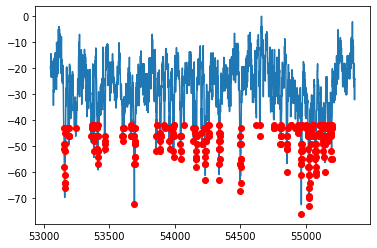

In [ ]:
gps_y = gps_y - np.polyval(np.polyfit(gps_x, gps_y, 2), gps_x)  # remove second order trend
gps_y = gps_y - gps_y.max()               # move max deflection value to zero
print(f'max deflection: {gps_y.min():.1f} mm')
gps = np.c_[gps_x, gps_y]                 # numpy matrix from x, y vectors
gpss_bus = gps[gps[:,1] < critical]
print(f'{gps_bus.shape[0]} seconds under critical')
plt.plot(gps_x, gps_y)
plt.plot(gps_bus[:,0], gps_bus[:,1], 'ro')


Finaly let's try to estimate the bus passes and save them to a file.

In [ ]:
start = 0                               # start row index of the first bus
gbus = []
for i in range(1, gps_bus.shape[0]):    # for each row except first
  if gps_bus[i,0] - gps_bus[i-1,0] > 1: # gap -> new bus arrived
    if i-start-1 > 2:                   # pass longer than 2 seconds?
      gbus.append((np.average(gps_bus[start:i,0]),
                  np.min(gps_bus[start:i,1]),
                  i-start-1))           # store time, max deflection and duration (sec)
    start = i
# add last
if gps_bus.shape[0] - start > 2:
  gbus.append((np.average(gps_bus[start:,0]),
              np.min(gps_bus[start:,1]),
              gps_bus.shape[0]-start))
print(f'{len(gbus)} busses found')
print(f'time  max.defl.  duration')
fo = open('sample_data/gps_bus.txt', 'w')
for b in gbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()


26 busses found
time  max.defl.  duration
14:45:59 -66.0    11
14:49:43 -52.0     5
14:50:10 -57.0     9
14:51:04 -51.0     3
14:53:24 -48.0     3
14:54:26 -46.0     3
14:54:53 -72.0    11
14:58:10 -52.0     5
14:59:49 -54.0     5
15:00:43 -55.0     5
15:02:42 -58.0     7
15:03:52 -63.0     7
15:05:39 -63.0    11
15:08:20 -67.0    11
15:12:34 -43.0     3
15:13:29 -49.0     8
15:14:16 -60.0     8
15:16:05 -76.0    10
15:17:03 -73.0    16
15:17:20 -49.0     4
15:17:54 -61.0    11
15:18:49 -52.0     6
15:19:04 -60.0    10
15:19:28 -48.0     5
15:19:41 -45.0     3
15:19:55 -55.0    10


Let's display the results:

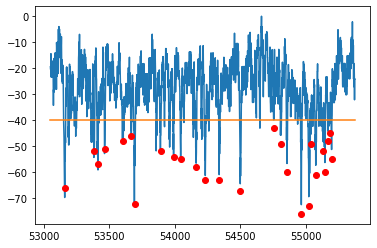

In [ ]:
plt.plot(gps_x, gps_y)
plt.plot([gps_x.min(), gps_x.max()], [critical, critical])
plt.plot([b[0] for b in gbus], [b[1] for b in gbus], 'ro')

Now, let's merge both the RTS and GPS result files, and try to find matches:

In [ ]:
i = 0   # index for rts bus
j = 0   # index for gps bus
ni = len(bus)
nj = len(gbus)
while True:
  if i < ni and j < nj:
    if bus[i][0] < gbus[j][0]:
      print(f'{datetime.fromtimestamp(bus[i][0]).strftime("%H:%M:%S"):8s} {bus[i][1]:5.1f} {bus[i][2]:5d} TPS')
      i += 1
    else:
      print(f'{datetime.fromtimestamp(gbus[j][0]).strftime("%H:%M:%S"):8s} {gbus[j][1]:5.1f} {gbus[j][2]:5d} GPS ***')
      j += 1
  elif i < ni:
    print(f'{datetime.fromtimestamp(bus[i][0]).strftime("%H:%M:%S"):8s} {bus[i][1]:5.1f} {bus[i][2]:5d} TPS')
    i += 1
  elif j < nj:
    print(f'{datetime.fromtimestamp(gbus[j][0]).strftime("%H:%M:%S"):8s} {gbus[j][1]:5.1f} {gbus[j][2]:5d} GPS ***')
    j += 1
  else:
    break

14:45:59 -66.0    11 GPS ***
14:49:41 -39.0     5 TPS
14:49:43 -52.0     5 GPS ***
14:50:10 -43.1     8 TPS
14:50:10 -57.0     9 GPS ***
14:51:02 -35.2     5 TPS
14:51:04 -51.0     3 GPS ***
14:53:21 -32.5     5 TPS
14:53:24 -48.0     3 GPS ***
14:54:26 -46.0     3 GPS ***
14:54:51 -45.5    11 TPS
14:54:53 -72.0    11 GPS ***
14:57:38 -43.3     7 TPS
14:58:09 -44.3     9 TPS
14:58:10 -52.0     5 GPS ***
14:59:19 -40.1     6 TPS
14:59:48 -35.0     3 TPS
14:59:49 -54.0     5 GPS ***
15:00:43 -55.0     5 GPS ***
15:00:43 -42.8     7 TPS
15:02:39 -44.2    11 TPS
15:02:42 -58.0     7 GPS ***
15:03:22 -36.0     4 TPS
15:03:50 -46.8    11 TPS
15:03:52 -63.0     7 GPS ***
15:05:39 -45.0     8 TPS
15:05:39 -63.0    11 GPS ***
15:08:19 -47.6     9 TPS
15:08:20 -67.0    11 GPS ***
15:10:18 -34.4     3 TPS
15:12:34 -43.0     3 GPS ***
15:13:28 -41.1     8 TPS
15:13:29 -49.0     8 GPS ***
15:14:15 -41.5     6 TPS
15:14:16 -60.0     8 GPS ***
15:16:04 -48.9    12 TPS
15:16:05 -76.0    10 GPS ***
15:

Using cross correlation, let's check how close the relation is between the RTS and the GPS data.

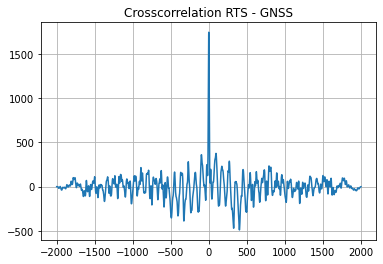

The time offset between RTS and GNSS data: -1


In [ ]:
def cross_corr(x1, y1, x2, y2):
    """ calculate normalized cross correlation between two data series

        :param x1: first data x
        :param y1: first data y
        :param x2: second data x
        :param y2: second data y
        :return lags and correlations
    """
    # find common range in x
    xmin = max(x1[0], x2[0])
    xmax = min(x1[-1], x2[-1])
    n = int(xmax - xmin)   # number of seconds
    x = np.linspace(xmin, xmax, n)
    yy1 = np.interp(x, x1, y1)
    yy2 = np.interp(x, x2, y2)
    yy1 = (yy1 - np.mean(yy1)) / (np.std(yy1))
    yy2 = (yy2 - np.mean(yy2)) / np.std(yy2)
    corr = np.correlate(yy1, yy2, "full")
    lags = np.arange(-n + 1, n)
    return lags, corr

lags, corr = cross_corr(rts_x, rts_y, gps_x, gps_y)
plt.plot(lags, corr)
plt.grid()
plt.title("Crosscorrelation RTS - GNSS")
plt.show()
print(f'The time offset between RTS and GNSS data: {lags[np.argmax(corr)]} seconds')


With the help of the cross-correlation, we can check the time offset of the two series (in the example, a time offset of -1). 
Based on that, let's check the crosscorrelation results by shifting the TPS observations:

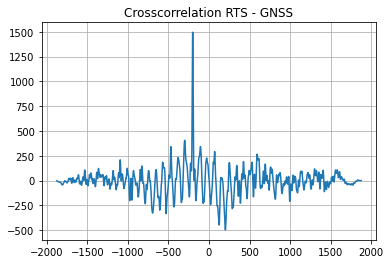

The time offset between RTS-200 and GNSS data: -201 seconds


In [ ]:
shift_rts_x = rts_x - 200   # shift with 200 seconds
lags, corr = cross_corr(shift_rts_x[150:], rts_y[150:], gps_x[:-149], gps_y[:-149])
plt.plot(lags, corr)
plt.grid()
plt.title("Crosscorrelation RTS - GNSS")
plt.show()
print(f'The time offset between RTS-200 and GNSS data: {lags[np.argmax(corr)]} seconds')


##Processing camera observations of ArUco marker

On the field it was used Ulyxes to get the position of the ArUco marker. The image coordinates of the ArUco marker are store in a SQLite database.

In [ ]:
!gdown --id 1gbNnIXP6ageJSf4cPc5XvpN2I1DI7a0f -O sample_data/db.sqlite

Downloading...
From: https://drive.google.com/uc?id=1gbNnIXP6ageJSf4cPc5XvpN2I1DI7a0f
To: /content/sample_data/db.sqlite
100% 176k/176k [00:00<00:00, 63.4MB/s]


In [ ]:
import sqlite3 as sql
conn = sql.connect('sample_data/db.sqlite')
cam_data = pd.read_sql('SELECT * FROM template_coo', conn, parse_dates=['datetime'])
print(f'{cam_data.shape[0]} records loaded')
print(f'Columns: {cam_data.columns}')

1948 records loaded
Columns: Index(['id', 'datetime', 'east', 'north', 'quality'], dtype='object')


Let's plot the camera data (north column and datetime)

Text(0.5, 1.0, 'Elevations')

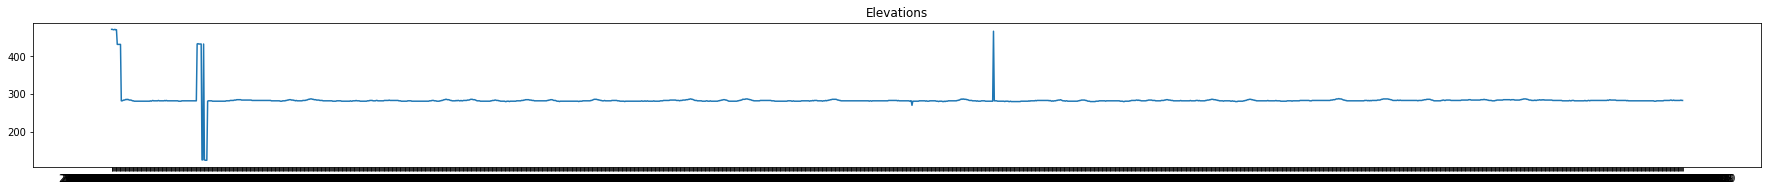

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(cam_data['datetime'], cam_data['north'])
ax.set_title('Elevations')

The figure above shows that there are some false positions. Let's use only those positions where the quality is above 0.9, changing the direction, and the pixels to millimeters.

In [ ]:
cam_data = pd.read_sql('SELECT * FROM template_coo WHERE quality > 0.9', conn, parse_dates=['datetime'])
print(f'{cam_data.shape[0]} records loaded')
print(f'Columns: {cam_data.columns}')
cam_data['north'] = -6 * cam_data['north']    # 1 pixel is ~6 mm

1866 records loaded
Columns: Index(['id', 'datetime', 'east', 'north', 'quality'], dtype='object')


Text(0.5, 1.0, 'Elevations')

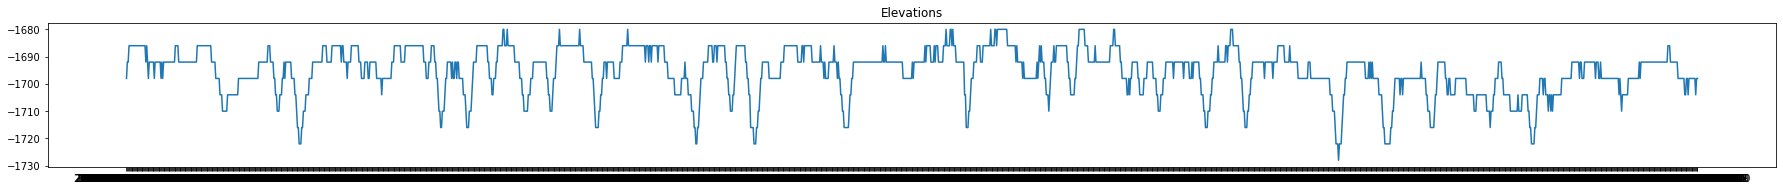

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(cam_data['datetime'], cam_data['north'])
ax.set_title('Elevations')

The figure above is less smooth when compared to the RTS and GNSS results. 
Do we have gaps in the data serie?

In [ ]:
deltas = cam_data['datetime'].diff()[1:]        # time difference from previous record
dd = deltas[deltas > timedelta(seconds=1)]  # select row where diff > 1 sec
print(f'{cam_data.shape[0]} records with {dd.size} gaps')

1866 records with 13 gaps


As it is possible to check, there are 13 gaps. Let's fill the gaps.

In [ ]:
t0 = cam_data['datetime'].min()
t0 = datetime(t0.year, t0.month, t0.day, 0, 0, 0)
dt = (cam_data['datetime'] - t0).dt.total_seconds()  # time difference from midnight
de = cam_data['north'] - cam_data['north'].max()
dt = dt.to_numpy().astype(int)
de = (de.to_numpy()).astype(int)
cam_x = np.arange(dt[0], dt[-1]+1)        # create serie of seconds
cam_y = np.interp(cam_x, dt, de)          # interpolate missing deflection (linear)
print(f'max deflection: {cam_y.min():.1f} mm')


max deflection: -48.0 mm


Now, let's prepare the data and display a chart with the critical deflections, where the *critical* values are based on the max deflection.

84 seconds under critical


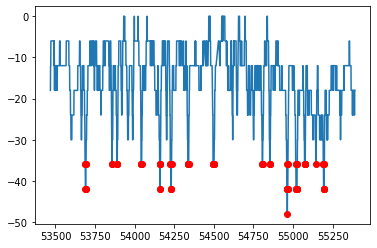

In [ ]:
critical = -35                            # critical deflection value
cam = np.c_[cam_x, cam_y]                 # numpy matrix from x, y vectors
cam_bus = cam[cam[:,1] < critical]        # select below critical
print(f'{cam_bus.shape[0]} seconds under critical')
plt.plot(cam_x, cam_y)                    # plot all data
plt.plot(cam_bus[:,0], cam_bus[:,1], 'ro')  # plot critical points

As it is possible to check, there is no significnt trend in the data. Finally, let's try to estimate the bus passes and save them to a file.

In [ ]:
start = 0                               # start row index of the first bus
cbus = []
for i in range(1, cam_bus.shape[0]):    # for each row except first
  if cam_bus[i,0] - cam_bus[i-1,0] > 1: # gap -> new bus arrived
    if i-start-1 > 2:                   # pass longer than 2 seconds?
      cbus.append((np.average(cam_bus[start:i,0]),
                  np.min(cam_bus[start:i,1]),
                  i-start-1))           # store time, max deflection and duration (sec)
    start = i
# add last
if cam_bus.shape[0] - start > 2:
  cbus.append((np.average(cam_bus[start:,0]),
              np.min(cam_bus[start:,1]),
              cam_bus.shape[0]-start))
print(f'{len(cbus)} busses found')
print(f'time  max.defl.  duration')
fo = open('sample_data/cam_bus.txt', 'w')
for b in cbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

10 busses found
time  max.defl.  duration
14:54:50 -42.0     6
15:00:42 -36.0     3
15:02:40 -42.0     5
15:03:49 -42.0     8
15:05:38 -36.0     5
15:08:18 -36.0     6
15:16:04 -48.0     8
15:17:02 -42.0    10
15:17:55 -36.0     4
15:19:54 -42.0     8


**Tasks**

*   Write a function to correct both TPS and GNSS input files
*   Enhance the merging algoritm, turning it into a function and showing only matching bus passes
*   Compare bus passes from camera data to the other two data sources, making best estimates for busses
*   Try to generalize the process of one data source, creating a function (which may call other functions) which can process RTS, GNSS or camera data

